In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("../input/usa-cers-dataset/USA_cars_datasets.csv")
df.head(3)


In [ ]:
#Grabbing column names
columns=df.columns.tolist()
print(columns)

In [ ]:
#Dropping some columns that are not useful for our EDA
df.drop(['Unnamed: 0','lot','vin'],axis=1,inplace=True)

In [ ]:
#Checking missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing=missing_data(df)
print(missing)

The quality of the data is ok and there are no missing data.

In [ ]:
#Let's check prices and mileage. If we want to deply a model in the feature, we should remove outliers from our data.
df.describe()

As we can see we have prices = 0 and a very strange mileage.. for the sake of this analysis I'll only remove the cars where prices = 0.

For this I'll use Pandasql library! 

Pandasql allows you to query pandas DataFrames using SQL syntax. It works similarly to sqldf in R. pandasql seeks to provide a more familiar way of manipulating and cleaning data for people new to Python or pandas. I used to work for a long time with SQL and it looks more intuitive to me.

In [ ]:
import pandasql as psql
sql=psql.sqldf

In [ ]:
df=sql('''select * from df where price !=0''')

In [ ]:
#To start our analysis, let's check which brand has more cars for sale and what is the average price
brand_prices=sql('''select brand, avg(price) from df group by brand order by avg(price) desc''')
plt.figure(figsize=(25,10))
sns.barplot(x='brand',y='avg(price)',data=brand_prices)
plt.xticks(rotation=90)

We can clearly see that some brands are more premium than others, this is the case of Harley-Davidson,Lincoln, Mercedez-Benz, Maserati, etc.

In [ ]:
#Which states have higher prices, in average?
state_prices=sql('''select state, avg(price) from df group by state order by avg(price) desc''')
plt.figure(figsize=(25,10))
sns.barplot(x='state',y='avg(price)',data=state_prices)
plt.xticks(rotation=90)

Kentucky prices seems so much higher than others? Let's investigate.

Households in Kentucky have a median annual income of 50,247 Dollars,which is less than the average income of 61,937 Dollars across the entire United States. This is in comparison to a median income of $48,375 in 2017, which represents a 3.87% annual growth. (Source: Google)


In [ ]:
kentucky=sql('''select brand,model,price from df where state="kentucky"''')
print (kentucky)

The majority of cars sold in Kentucky are ford models and they look pretty expensive! Funny enough there is a chevrolet being sold at a price tag of 25 bucks..

In [ ]:
#Lets compare Ford Prices across all the states so we can have a better picture of what's going on.

ford_prices=sql('''select state,brand, avg(price),count(model) from df
                where brand="ford"
                group by state, 
                brand order by avg(price) desc''')
print(ford_prices.head(5))

In [ ]:
#Number of Ford on Sale
plt.figure(figsize=(25,10))              
sns.barplot(x='state',y='count(model)',data=ford_prices.sort_values(by=['count(model)'],ascending=False))
plt.xticks(rotation=90)

In [ ]:
#Avg Price per State
plt.figure(figsize=(25,10))              
sns.barplot(x='state',y='avg(price)',data=ford_prices)
plt.xticks(rotation=90)

Washington has only one car for sale while Kentucky has 8, that's why the average for Washington is higher. 

In [ ]:
#Lets come back to exploration. I'm curious to know which models have higher mileage - without exploring I'd say the japanese brands are in the top, let's see.
brand_mileage=sql('''select brand,model,mileage,price from df where title_status="clean vehicle" order by mileage desc''')
print(brand_mileage.head(10))

Just one japanese brand, I'm bit surprised, they tend to be pretty reliable. The top 1 looks weird though..

In [ ]:
#Let's check mileage variation using boxplot chart.
plt.figure(figsize=(25,10))   
sns.boxplot(x='brand',y='mileage',data=brand_mileage)

In [ ]:
#lets compare the prices by maker
#1st let's create a new column with the region of the maker.
df['brand'].unique()

brands_dict={'toyota':'JPN', 'ford':'USA', 'dodge':'USA', 'chevrolet':'USA', 'gmc':'USA', 'chrysler':'USA', 'kia':'SKR',
       'buick':'USA', 'infiniti':'JPN', 'mercedes-benz':'GER', 'jeep':'USA', 'bmw':'GER', 'cadillac':'USA',
       'hyundai':'SKR', 'mazda':'JPN', 'honda':'JPN', 'heartland':'Other', 'jaguar':'ENG', 'acura':'JPN',
       'harley-davidson':'USA', 'audi':'GER', 'lincoln':'USA', 'lexus':'JPN', 'nissan':'JPN', 'land':'ENG',
       'maserati':'ITA', 'peterbilt':'USA', 'ram':'USA'}

df['brand_region']= df['brand'].map(brands_dict)

In [ ]:
#Scatter shot comparing mileage x price by region
brandregion_mileage=sql('''select brand,brand_region,mileage,price from df where title_status="clean vehicle" order by mileage desc''')
plt.figure(figsize=(25,10))              
sns.scatterplot(x='price',y='mileage',data=brandregion_mileage,hue='brand_region')
plt.xticks(rotation=90)

The price distribution varies a lot while the mileage seems to be concentrated around the area where mileage<200000. Oh, the most expensive car is German, what a surprise, I thought it would be Italian (Masserati)

In [ ]:
#most expensive car is german - What's the model and where to find it?
top_expensive=sql('''select brand,model,state,mileage,year, max(price) from df''')
print(top_expensive)

That's why is so expensive..it is quite new car!

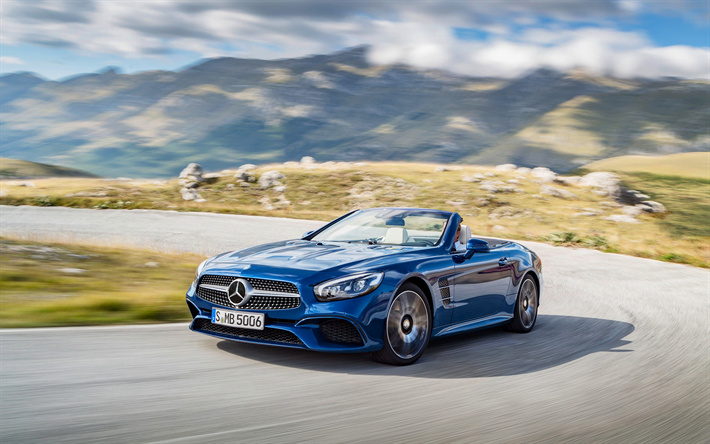

In [ ]:
#To practice a little bit more SQL..Lets create a table containing the prices by region and state

region_prices=sql('''select brand,brand_region,state,max(price),min(price),count(price) from df group by brand,brand_region,state order by count(price)desc ''')
print(region_prices)

In [ ]:
#What's the most popular colors?
colors=sql('''select color,count(color) from df group by color order by count(color) desc''')
plt.figure(figsize=(25,10))              
sns.barplot(x='color',y='count(color)',data=colors)
plt.xticks(rotation=90)

That's all for the moment. I wanted to show that is possible to combine SQL (which is very useful and requested in many companies) and Python. I hope you like it.

# Please upvote if you like it! I'm planning to update the kernel later with more stuff :)
